In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
# import seaborn as sns
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from itertools import product
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import KFold
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.preprocessing import MinMaxScaler
# from prophet import Prophet
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from catboost import CatBoostRegressor, Pool

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure TensorFlow operates deterministically
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

dow_jones_df = pd.read_csv("dow_jones_data_clean.csv")

# Display the first few rows and column names of the dataset
dow_jones_df.head(), dow_jones_df.columns

2024-12-05 19:22:30.115839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(                        Date  Adj Close     Close      High       Low  \
 0  1980-12-12 00:00:00+00:00   0.098943  0.128348  0.128906  0.128348   
 1  1980-12-15 00:00:00+00:00   0.093781  0.121652  0.122210  0.121652   
 2  1980-12-16 00:00:00+00:00   0.086898  0.112723  0.113281  0.112723   
 3  1980-12-17 00:00:00+00:00   0.089049  0.115513  0.116071  0.115513   
 4  1980-12-18 00:00:00+00:00   0.091630  0.118862  0.119420  0.118862   
 
        Open     Volume Ticker  
 0  0.128348  469033600   AAPL  
 1  0.122210  175884800   AAPL  
 2  0.113281  105728000   AAPL  
 3  0.115513   86441600   AAPL  
 4  0.118862   73449600   AAPL  ,
 Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
        'Ticker'],
       dtype='object'))

In [2]:
dow_jones_df.info()
dow_jones_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361538 entries, 0 to 361537
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       361538 non-null  object 
 1   Adj Close  361538 non-null  float64
 2   Close      361538 non-null  float64
 3   High       361538 non-null  float64
 4   Low        361538 non-null  float64
 5   Open       361538 non-null  float64
 6   Volume     361538 non-null  int64  
 7   Ticker     361538 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 22.1+ MB


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
count,361538,361538.000000,361538.000000,361538.000000,361538.000000,361538.000000,3.615380e+05,361538
unique,15821,NaN,NaN,NaN,NaN,NaN,NaN,28
top,2012-04-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,KO
freq,28,NaN,NaN,NaN,NaN,NaN,NaN,15821
mean,NaN,34.735950,44.823122,45.261430,44.365490,44.636039,2.053661e+07,NaN
std,NaN,59.699655,64.121151,64.724787,63.490108,64.223467,8.102556e+07,NaN
min,NaN,0.002845,0.005208,0.005208,0.004801,0.000000,0.000000e+00,NaN
25%,NaN,1.324075,4.270833,4.312500,4.226386,3.733622,2.124347e+06,NaN
50%,NaN,11.948401,21.945000,22.187500,21.690001,21.920000,5.294992e+06,NaN
75%,NaN,40.156898,55.970001,56.500000,55.408287,55.972920,1.253280e+07,NaN


In [3]:
# Check for missing values
missing_values = dow_jones_df.isnull().sum()
missing_values

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
dtype: int64

In [4]:
# Convert 'Date' column to datetime format
dow_jones_df['Date'] = pd.to_datetime(dow_jones_df['Date'])

# Set 'Date' as the index
dow_jones_df.set_index('Date', inplace=True)

# Display the updated DataFrame
dow_jones_df.head()

,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
1980-12-12 00:00:00+00:00,0.098943,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1980-12-15 00:00:00+00:00,0.093781,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
1980-12-16 00:00:00+00:00,0.086898,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
1980-12-17 00:00:00+00:00,0.089049,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
1980-12-18 00:00:00+00:00,0.091630,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


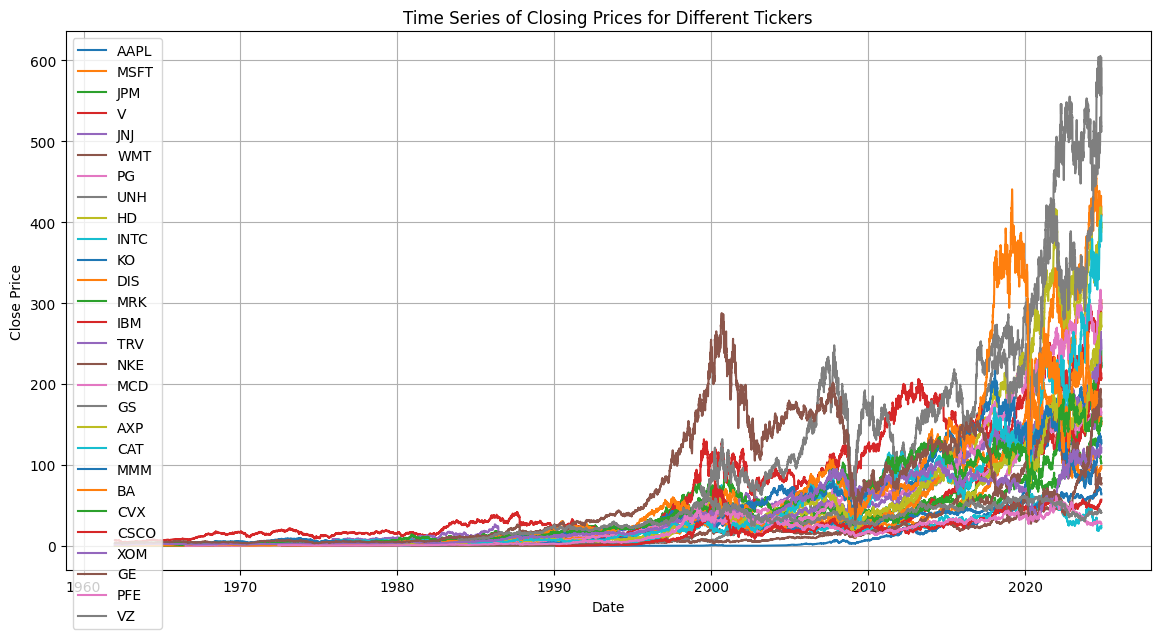

In [5]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Close'], label=ticker)

plt.title('Time Series of Closing Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

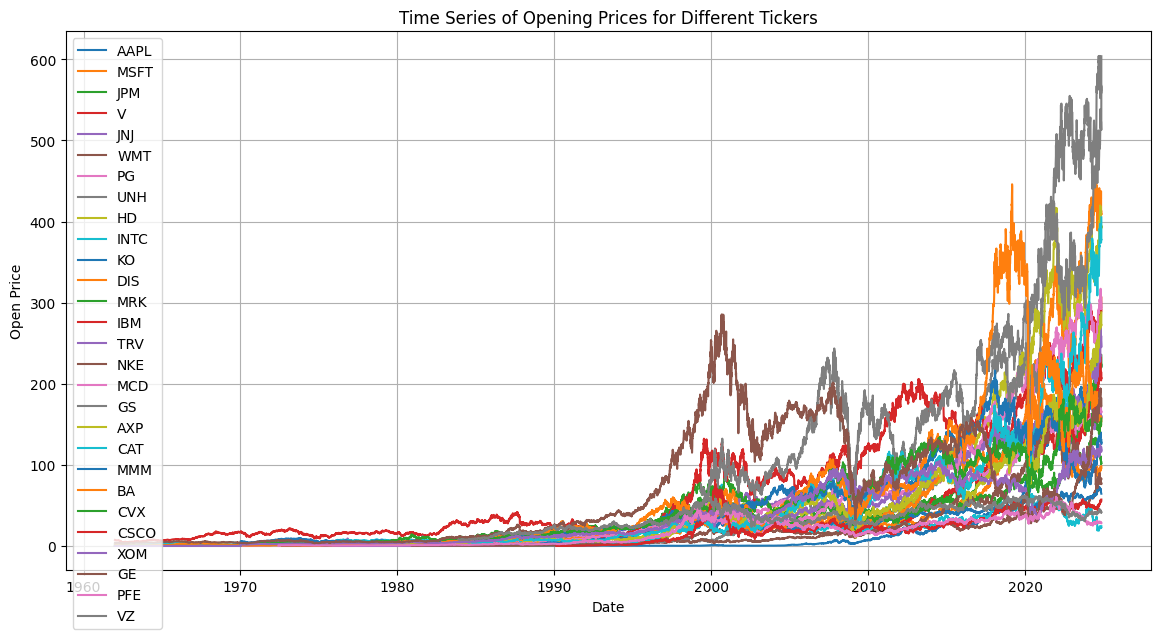

In [6]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Open'], label=ticker)

plt.title('Time Series of Opening Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.show()

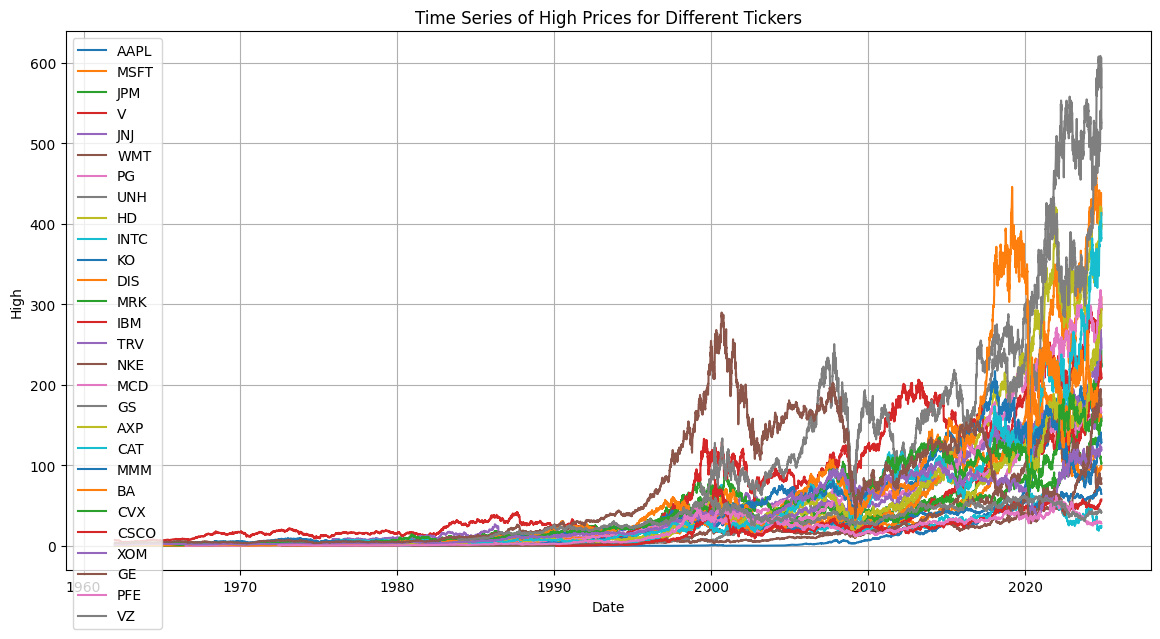

In [7]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['High'], label=ticker)

plt.title('Time Series of High Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.show()

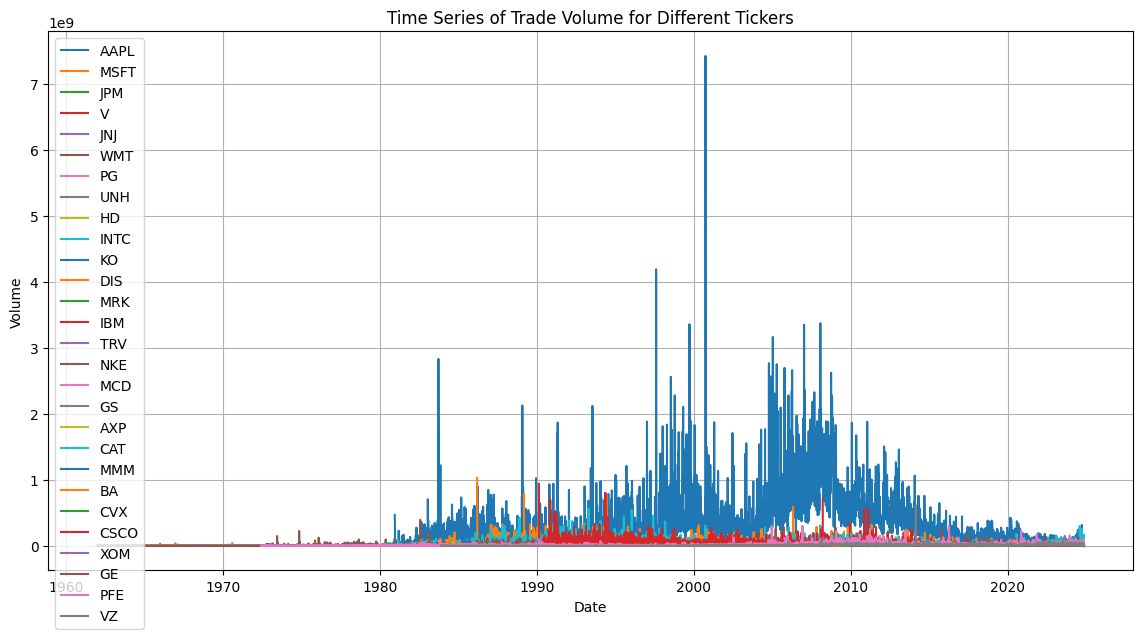

In [8]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Volume'], label=ticker)

plt.title('Time Series of Trade Volume for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

## AAPL data graphing

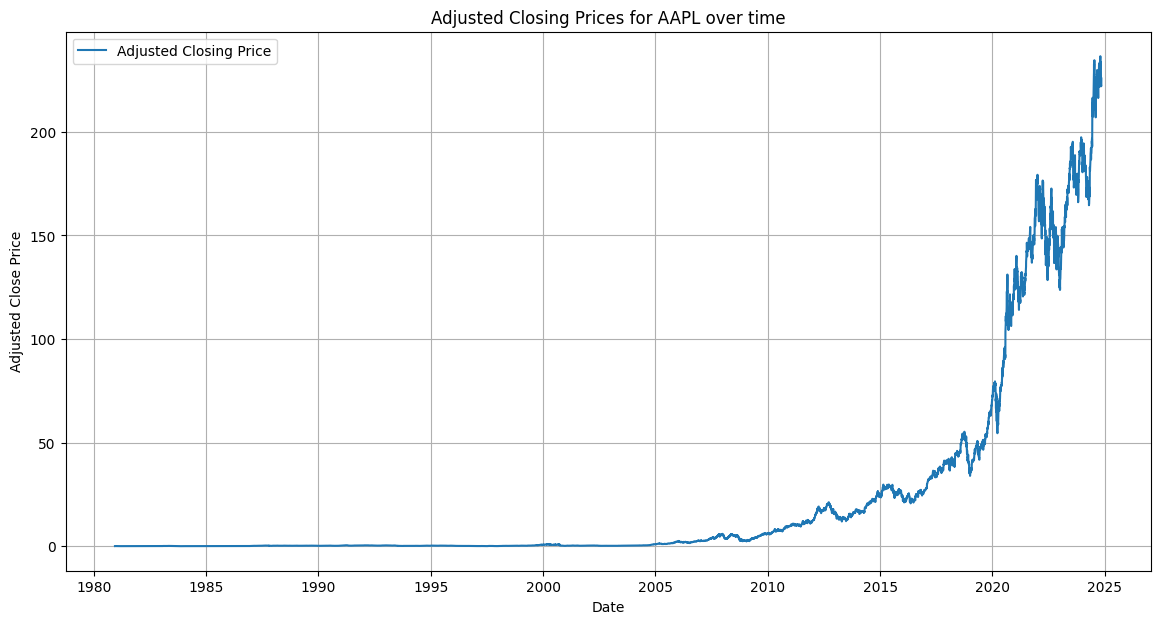

In [9]:
AAPL_data =  dow_jones_df[dow_jones_df['Ticker'] == "AAPL"]
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Adj Close'], label= 'Adjusted Closing Price')
plt.title('Adjusted Closing Prices for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

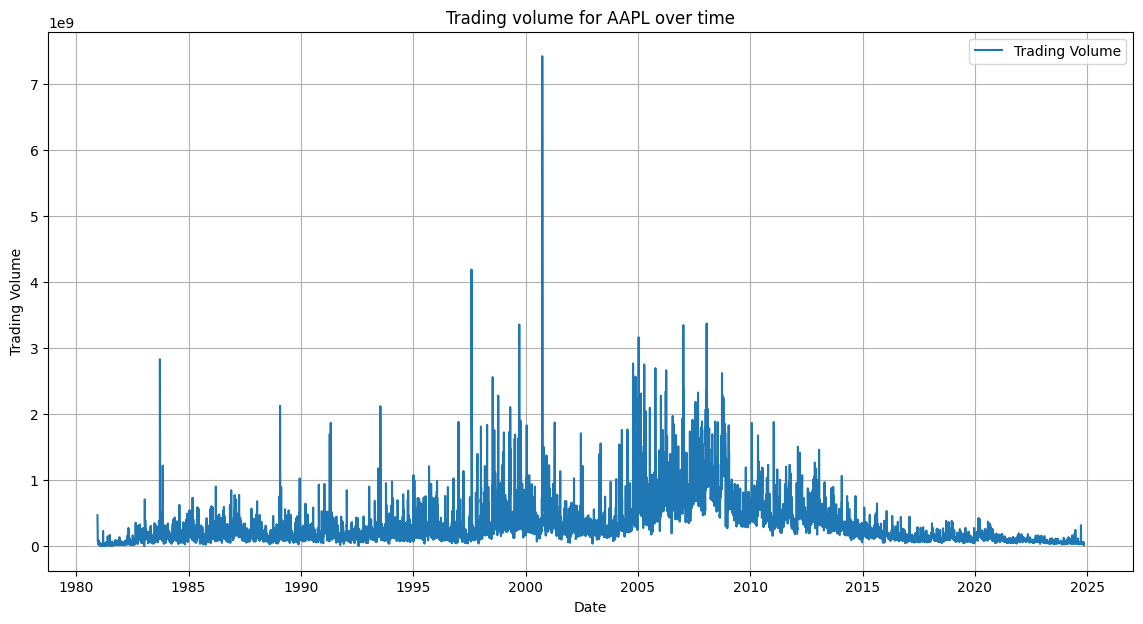

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Volume'], label= 'Trading Volume')
plt.title('Trading volume for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.legend()
plt.grid(True)
plt.show()

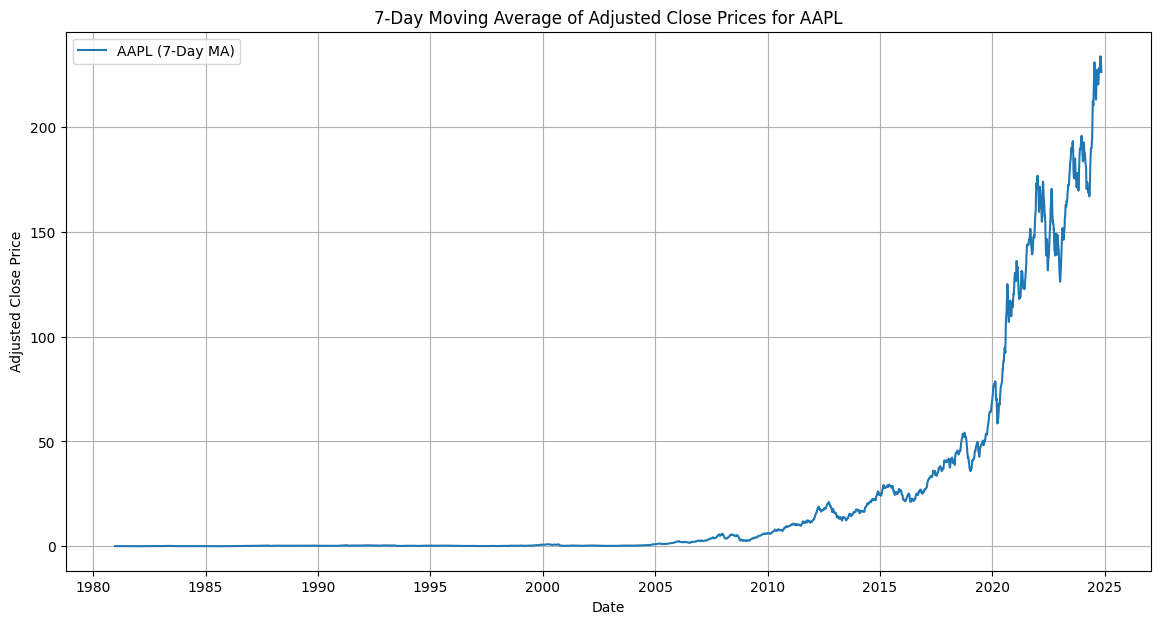

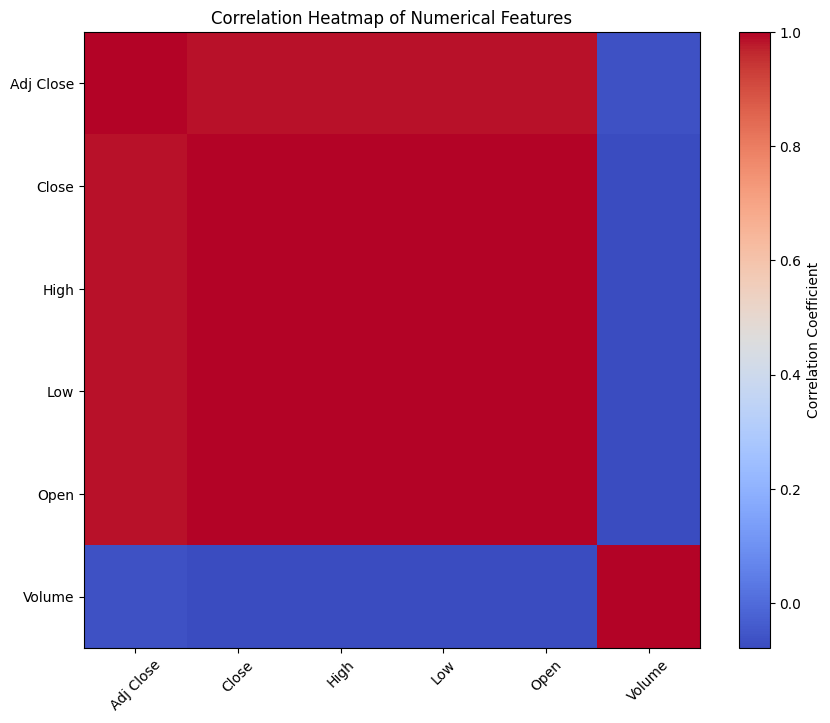

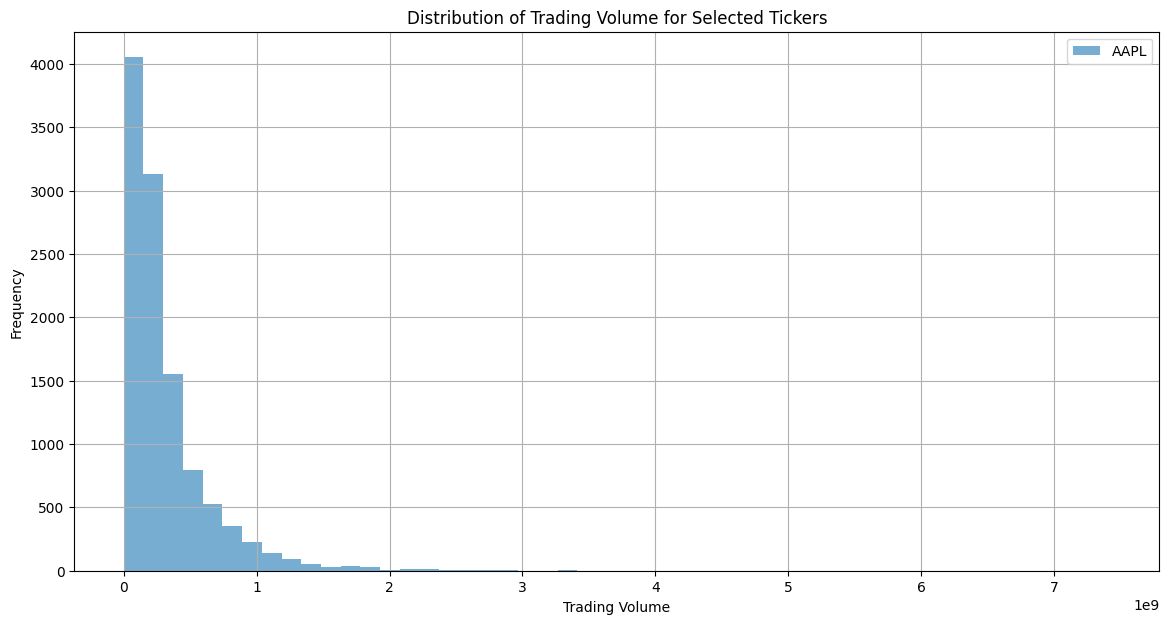

In [11]:
selected_tickers = ['AAPL']
plt.figure(figsize=(14, 7))
for ticker in selected_tickers:
    ticker_data = AAPL_data[AAPL_data['Ticker'] == ticker]
    ticker_data['7-Day MA'] = ticker_data['Adj Close'].rolling(window=7).mean()
    plt.plot(ticker_data.index, ticker_data['7-Day MA'], label=f"{ticker} (7-Day MA)")

plt.title("7-Day Moving Average of Adjusted Close Prices for AAPL")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Correlation Heatmap for numerical features
numerical_data = dow_jones_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap of Numerical Features")
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(numerical_data.columns)), numerical_data.columns, rotation=45)
plt.yticks(range(len(numerical_data.columns)), numerical_data.columns)
plt.grid(False)
plt.show()

# Distribution of Trading Volume for the selected tickers
plt.figure(figsize=(14, 7))
for ticker in selected_tickers:
    ticker_data = AAPL_data[AAPL_data['Ticker'] == ticker]
    plt.hist(ticker_data['Volume'], bins=50, alpha=0.6, label=ticker)

plt.title("Distribution of Trading Volume for Selected Tickers")
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

### Exploring seasonal decompose for AAPL data

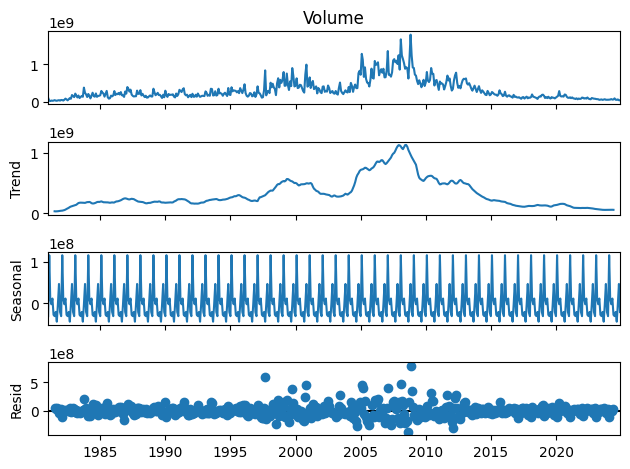

<Figure size 1000x600 with 0 Axes>

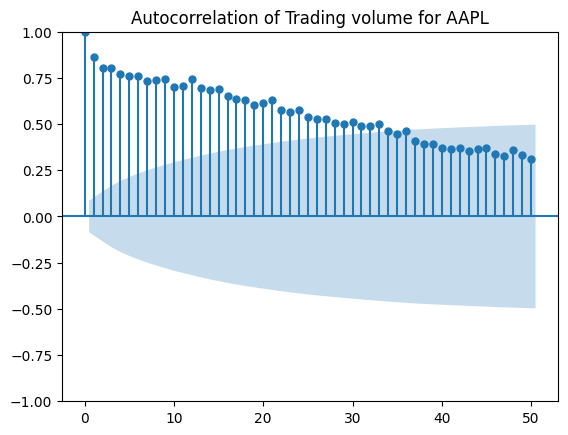

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Decompose the time series (monthly data)
AAPLmonthly_data = AAPL_data['Volume'].resample('M').mean()
decomposition = seasonal_decompose(AAPLmonthly_data, model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

# Plot the ACF to check for seasonality
plt.figure(figsize=(10, 6))
plot_acf(AAPLmonthly_data, lags=50, title='Autocorrelation of Trading volume for AAPL')
plt.show()

## Modeling

### ARIMA

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(AAPL_data['Volume'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.402609038045689
p-value: 3.3447258277548513e-06


Since the p-value is > 0.5 the data is non-stationary and need differencing.

ARIMA requires a stationary series (constant mean and variance over time). Will use Augmented Dickey-Fuller to check for stationarity.

In [14]:
# Apply differencing
AAPL_data['Volume_diff'] = AAPL_data['Volume'].diff().dropna()

/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_13276/1211233123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_data['Volume_diff'] = AAPL_data['Volume'].diff().dropna()


In [15]:
# Split data into train and test
train_data = AAPL_data[AAPL_data.index <= '2017-12-31']['Volume_diff']
test_data = AAPL_data[(AAPL_data.index > '2017-12-31') & (AAPL_data.index <= '2020-12-31')]['Volume_diff']

In [18]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
# Define parameter ranges
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

# Track the best model
best_aic = float('inf')
best_order = None
best_model = None

# Grid search through all combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception:
        continue

# Display the best parameters and AIC score
best_order, best_aic

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

((1, 0, 2), 384274.7445587093)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


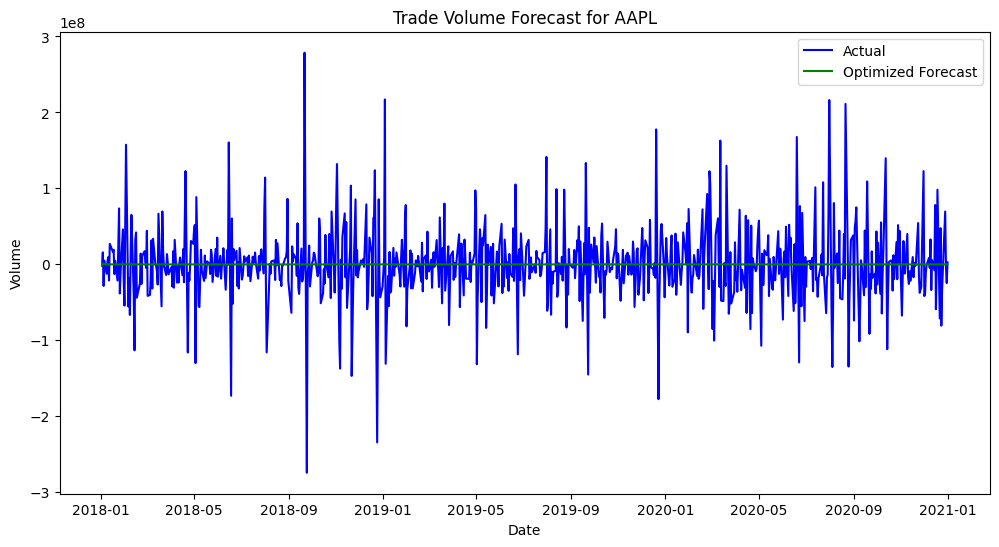

In [19]:
optimized_model = ARIMA(train_data, order=best_order)
fitted_optimized_model = optimized_model.fit()
optimized_forecast = fitted_optimized_model.forecast(steps=len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, optimized_forecast, label="Optimized Forecast", color="green")
plt.title('Trade Volume Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
optimized_mae = mean_absolute_error(test_data, optimized_forecast)
optimized_rmse = np.sqrt(mean_squared_error(test_data, optimized_forecast))
optimized_mae, optimized_rmse

(33937664.177950546, 49907308.3709498)

### LSTM

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.0011 - val_loss: 7.3075e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 7.0384e-04 - val_loss: 6.6106e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 6.4685e-04 - val_loss: 6.3261e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 6.3165e-04 - val_loss: 6.4346e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 6.1658e-04 - val_loss: 6.3471e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 5.8795e-04 - val_loss: 7.1359e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 5.9244e-04 - val_loss: 6.7083e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 5.9007e-04 - val_loss: 7.1789e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0011 - val_loss: 9.1992e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 7.1139e-04 - val_loss: 8.7530e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 6.8329e-04 - val_loss: 8.6071e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.6798e-04 - val_loss: 8.2453e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.4825e-04 - val_loss: 8.5039e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.3397e-04 - val_loss: 8.4356e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.4585e-04 - val_loss: 8.1924e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.4199e-04 - val_loss: 8.0578e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.4684e-04 - val_loss: 8.1494e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.3080e-04 - val_loss: 7.9809e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0011 - val_loss: 6.7107e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 8.4079e-04 - val_loss: 5.9843e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 7.7874e-04 - val_loss: 5.8297e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 7.5018e-04 - val_loss: 5.5433e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 7.2096e-04 - val_loss: 5.1875e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 7.1173e-04 - val_loss: 4.9948e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 6.9990e-04 - val_loss: 5.0002e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 7.0146e-04 - val_loss: 5.0358e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 6.9430e-04 - val_loss: 5.1182e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 7.0916e-04 - val_loss: 4.9316e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - loss: 0.0012 - val_loss: 6.2790e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 8.3917e-04 - val_loss: 5.9353e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 7.9497e-04 - val_loss: 5.9384e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 7.3631e-04 - val_loss: 5.9246e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 7.2133e-04 - val_loss: 6.0570e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 7.0749e-04 - val_loss: 5.9416e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 7.0359e-04 - val_loss: 6.0729e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 7.0309e-04 - val_loss: 5.9417e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.8181e-04 - val_loss: 6.0919e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 9.7303e-04 - val_loss: 0.0012
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 7.4076e-04 - val_loss: 0.0011
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.8194e-04 - val_loss: 0.0011
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.6175e-04 - val_loss: 0.0010
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.4898e-04 - val_loss: 0.0010
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 6.3650e-04 - val_loss: 0.0010
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.3052e-04 - val_loss: 0.0010
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.4203e-04 - val_loss: 9.9929e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.2861e-04 - val_loss: 9.9539e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 6.4702e-04 - val_loss: 9.9582e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


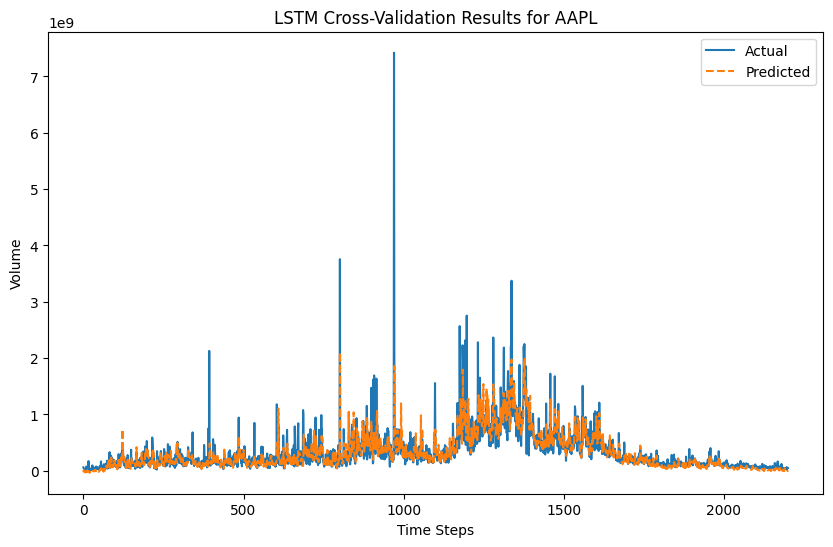

Cross-Validation Results for AAPL:
Fold MSE: [3.484465232023534e+16, 4.395952231929473e+16, 2.716356763623373e+16, 3.2632968165553268e+16, 5.482709078601764e+16]
Average MSE: 38685560245466936.0000
Results for AAPL:
Average MSE: 38685560245466936.0000


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Cross-validation results storage
cv_results = {}

# Loop through each stock ticker in the dataset
# for ticker in dow_jones_df['Ticker'].unique():
ticker = 'AAPL'

stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]['Volume'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data)

# Create sequences of 60 time steps
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(stock_data_scaled, time_steps)

# Reshape input for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mse = []
predictions_all_folds = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model with Dropout to prevent overfitting
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # EarlyStopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])

    # Make predictions on the test fold
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and store MSE for this fold
    mse = mean_squared_error(y_test_actual, predictions)
    fold_mse.append(mse)

    # Store predictions for visualization
    predictions_all_folds.append((y_test_actual, predictions))

# Store overall results for this stock
cv_results[ticker] = {
    'mse': fold_mse,
    'avg_mse': np.mean(fold_mse),
    'predictions': predictions_all_folds
}

# Plot actual vs predicted for the last fold
plt.figure(figsize=(10, 6))
plt.plot(predictions_all_folds[-1][0], label='Actual')
plt.plot(predictions_all_folds[-1][1], label='Predicted', linestyle='--')
plt.title(f'LSTM Cross-Validation Results for {ticker}')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

print(f"Cross-Validation Results for {ticker}:")
print(f"Fold MSE: {fold_mse}")
print(f"Average MSE: {np.mean(fold_mse):.4f}")

# Example: Access cross-validation results for a specific stock
ticker_example = list(cv_results.keys())[0]
print(f"Results for {ticker_example}:")
print(f"Average MSE: {cv_results[ticker_example]['avg_mse']:.4f}")


# Prepare to store results
lstm_results = {}

# Loop through each stock ticker in the dataset
for ticker in dow_jones_df['Ticker'].unique():
    stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]['Volume'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data_scaled = scaler.fit_transform(stock_data)

    # Create sequences of 60 time steps
    def create_sequences(data, time_steps=60):
        X, y = [], []
        for i in range(time_steps, len(data)):
            X.append(data[i - time_steps:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    time_steps = 60
    X, y = create_sequences(stock_data_scaled, time_steps)

    # Split into training and testing sets (80-20)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    # Inverse transform actual values
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store results
    lstm_results[ticker] = {
        'model': model,
        'predictions': predictions,
        'actual': y_test_actual
    }

    # Plot actual vs predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(predictions, label='Predicted', linestyle='--')
    plt.title(f'Trade Volume Forecast with LSTM for {ticker}')
    plt.xlabel('Time Steps')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

# Example: Access LSTM predictions for a specific stock
ticker_example = list(lstm_results.keys())[0]
print(f"LSTM Predictions for {ticker_example}:")
print(lstm_results[ticker_example]['predictions'][:5])

## LSTM hyperparameter tuning


from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameter grid
param_grid = {
    'lstm_units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'epochs': [20]
}

# Scale the volume data
scaler = MinMaxScaler(feature_range=(0, 1))
AAPL_volume_scaled = scaler.fit_transform(AAPL_volume)

# Create sequences
time_steps = 60
X, y = create_sequences(AAPL_volume_scaled, time_steps)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_params = None
lowest_mse = float('inf')

# Hyperparameter tuning
for params in ParameterGrid(param_grid):
    fold_mse = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the model
        model = Sequential([
            LSTM(params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(params['dropout_rate']),
            LSTM(params['lstm_units'], return_sequences=False),
            Dropout(params['dropout_rate']),
            Dense(25),
            Dense(1)
        ])

        # Compile the model with custom learning rate
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Callbacks for early stopping and learning rate reduction
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

        # Train the model
        model.fit(X_train, y_train,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop, lr_reduce])

        # Predictions and MSE
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        mse = mean_squared_error(y_test_actual, predictions)
        fold_mse.append(mse)

    # Average MSE for the current set of parameters
    avg_mse = np.mean(fold_mse)

    print(f"Params: {params}, Average MSE: {avg_mse:.4f}")

    # Update best parameters
    if avg_mse < lowest_mse:
        lowest_mse = avg_mse
        best_params = params

print("\nBest Parameters:", best_params)
print("Lowest Average MSE:", lowest_mse)

# Final model training with best parameters
model = Sequential([
    LSTM(best_params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units'], return_sequences=False),
    Dropout(best_params['dropout_rate']),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y,
          batch_size=best_params['batch_size'],
          epochs=best_params['epochs'],
          verbose=1)

# Plot actual vs predicted for the final model
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.title('LSTM Results for AAPL with Best Hyperparameters')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

### Prophet

In [26]:
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

19:39:34 - cmdstanpy - INFO - Chain [1] start processing
19:39:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


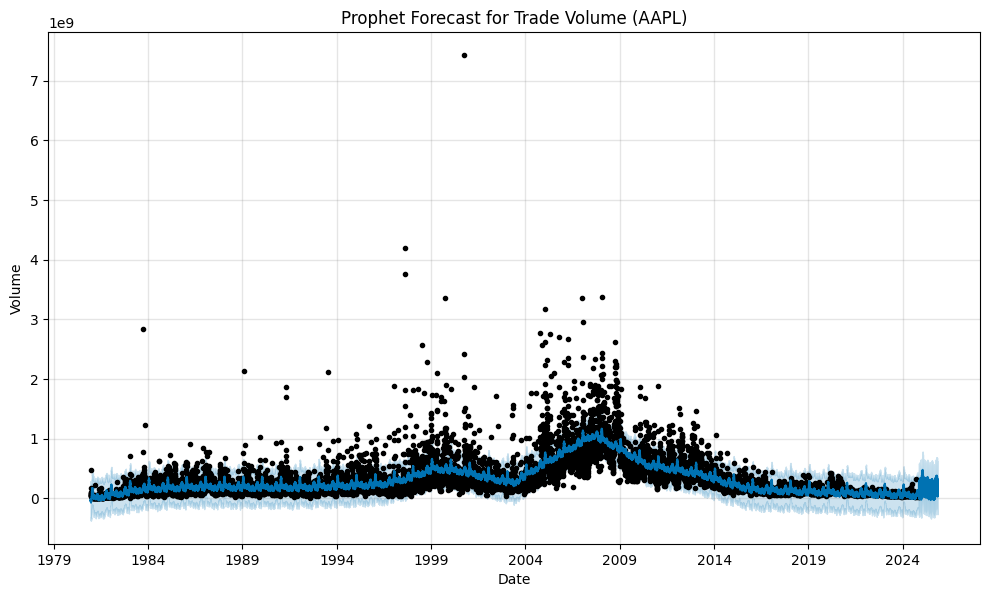

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

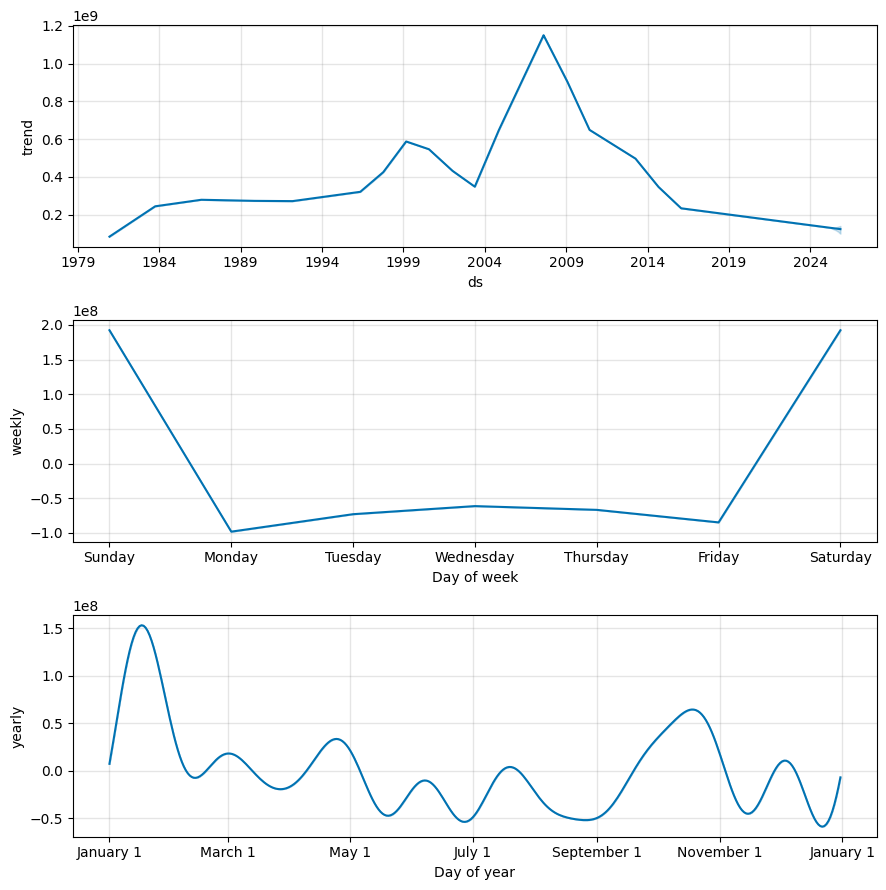

In [27]:
# Filter data for the specified ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Prepare the data for Prophet
prophet_data = stock_data[['Volume']].reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires columns 'ds' for dates and 'y' for values

# Remove timezone from 'ds' column
prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=365)  # Extend the forecast for 365 days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Prophet Forecast for Trade Volume ({ticker})')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()


19:39:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing


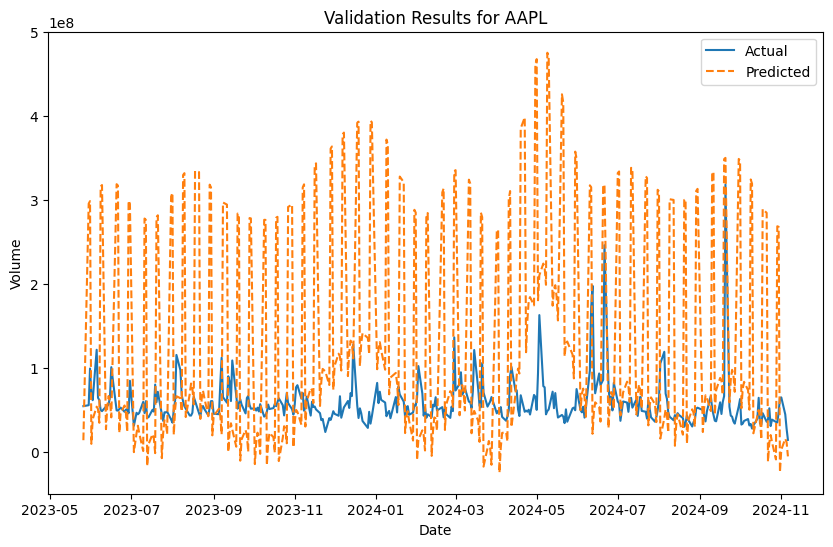

In [28]:
# Split data into training and validation sets
train = prophet_data.iloc[:-365]
validation = prophet_data.iloc[-365:]

# Instantiate a new Prophet model
validation_model = Prophet()

# Fit the model on the training data
validation_model.fit(train)

# Make predictions for the validation set
validation_future = validation_model.make_future_dataframe(periods=len(validation))
validation_forecast = validation_model.predict(validation_future)

# Compare actual vs. predicted
validation_results = pd.DataFrame({
    'ds': validation['ds'],
    'Actual': validation['y'],
    'Predicted': validation_forecast['yhat'].iloc[-len(validation):].values
})

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(validation_results['ds'], validation_results['Actual'], label='Actual')
plt.plot(validation_results['ds'], validation_results['Predicted'], label='Predicted', linestyle='--')
plt.title(f'Validation Results for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


### Exponential Smoothing

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error: 7144222430775878.0000


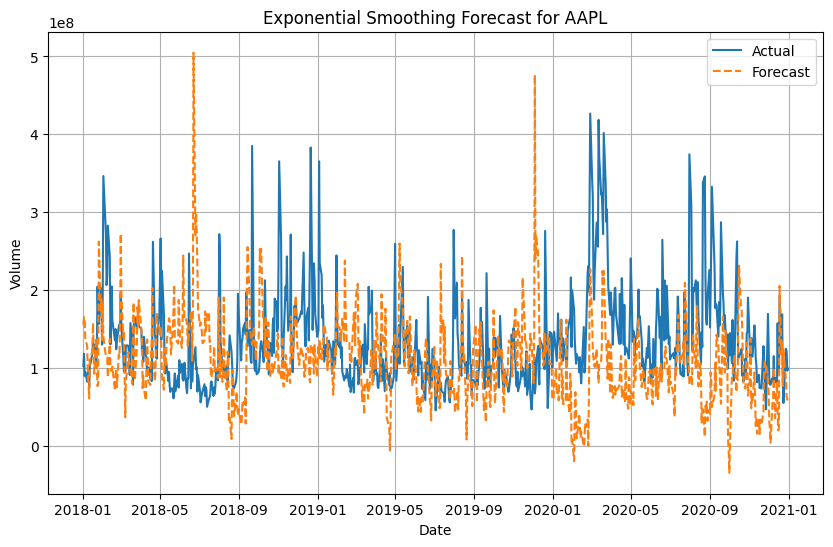

In [31]:
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
volume_data = stock_data['Volume']

train = volume_data[volume_data.index <= '2017-12-31']
test = volume_data[(volume_data.index > '2017-12-31') & (volume_data.index <= '2020-12-31')]

# Fit the Exponential Smoothing model with trend and seasonality
model = ExponentialSmoothing(
    train,
    trend="additive",   # Additive trend
    seasonal="additive",  # Additive seasonality
    seasonal_periods=365,  # Define seasonal periods
)
fitted_model = model.fit(optimized=True)

# Forecast for the test period
forecast = fitted_model.forecast(steps=len(test))

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f'Exponential Smoothing Forecast for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### CatBoost

In [ ]:
# Filter data for the specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Ensure the index is sorted
stock_data.sort_index(inplace=True)

# Add lag features and rolling statistics
def create_features(data, target_col, lags=[1, 7, 30], rolling_windows=[7, 30]):
    df = data.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

# Prepare the dataset
stock_data = create_features(stock_data, target_col='Volume')

# Train-test split (80-20)
train_size = int(len(stock_data) * 0.8)
train = stock_data.iloc[:train_size]
test = stock_data.iloc[train_size:]

# Define features and target
X_train = train.drop('Volume', axis=1)
y_train = train['Volume']
X_test = test.drop('Volume', axis=1)
y_test = test['Volume']

# Specify categorical features (e.g., Ticker)
cat_features = [X_train.columns.get_loc('Ticker')]  # Index of the 'Ticker' column

# Define CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=20000,
    depth=10,
    learning_rate=0.05,
    loss_function='RMSE',
    eval_metric='RMSE',
    verbose=50,
    early_stopping_rounds=5000
)

# Train the model
print("Training CatBoost model...")
catboost_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)

# Make predictions
print("Making predictions...")
predictions = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"CatBoost Mean Squared Error: {mse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Predicted', color='orange', linestyle='--')
plt.title(f'CatBoost Forecast for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
cv_mse = []
cv_predictions = []

# Filter data for the specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Ensure the index is sorted
stock_data.sort_index(inplace=True)

# Add lag features and rolling statistics
def create_features(data, target_col, lags=[1, 7, 30], rolling_windows=[7, 30]):
    df = data.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

# Prepare the dataset
stock_data = create_features(stock_data, target_col='Volume')

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(stock_data)):
    print(f"Fold {fold + 1}")
    
    # Split data into training and testing sets for this fold
    train, test = stock_data.iloc[train_index], stock_data.iloc[test_index]
    X_train, y_train = train.drop('Volume', axis=1), train['Volume']
    X_test, y_test = test.drop('Volume', axis=1), test['Volume']
    
    # Specify categorical features (e.g., Ticker)
    cat_features = [X_train.columns.get_loc('Ticker')]  # Index of the 'Ticker' column

    # Define CatBoost Regressor
    catboost_model = CatBoostRegressor(
        iterations=20000,
        depth=10,
        learning_rate=0.05,
        loss_function='RMSE',
        eval_metric='RMSE',
        verbose=50,
        early_stopping_rounds=5000
    )

    # Train the model
    catboost_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True) 
    
    # Make predictions
    predictions = catboost_model.predict(X_test)

    # Calculate MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    cv_mse.append(mse)

    # Store predictions for analysis
    cv_predictions.append((y_test, predictions))

    print(f"Fold {fold + 1} MSE: {mse:.4f}")

# Print Cross-Validation Results
print("\nCross-Validation Results:")
print(f"Mean MSE: {np.mean(cv_mse):.4f}")
print(f"Standard Deviation of MSE: {np.std(cv_mse):.4f}")

# Plot actual vs predicted for the last fold
actual, predicted = cv_predictions[-1]
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual', color='blue')
plt.plot(actual.index, predicted, label='Predicted', color='orange', linestyle='--')
plt.title(f'CatBoost Cross-Validation - Fold {len(cv_predictions)}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### DeepAR

In [34]:
import gluonts

In [35]:
from gluonts.dataset.common import ListDataset

# Filter data for a specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker].sort_index()

# Prepare target and metadata
target = stock_data['Volume'].values
start_date = stock_data.index.min()

# Create the dataset
train_data = ListDataset(
    [{"start": start_date, "target": target[:-365]}],  # Exclude the last 365 days for testing
    freq="D"  # Daily frequency
)

test_data = ListDataset(
    [{"start": start_date, "target": target}],  # Use full data for evaluation
    freq="D"
)

In [36]:
import gluonts
print(gluonts.__version__)
print(dir(gluonts))

import gluonts.model
print(dir(gluonts.model))


0.16.0
['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'dataset', 'exceptions', 'extend_path', 'itertools', 'json', 'maybe', 'meta', 'pydantic']
['Estimator', 'Forecast', 'IncrementallyTrainable', 'Input', 'InputSpec', 'Predictor', 'QuantileForecast', 'SampleForecast', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'estimator', 'evaluate_forecasts', 'evaluate_model', 'evaluation', 'forecast', 'inputs', 'predictor']


In [39]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
torch.set_default_device("cpu")


In [42]:
import torch

# Set PyTorch to CPU
torch.set_default_device("cpu")

from gluonts.torch import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Define DeepAR estimator
estimator = DeepAREstimator(
    freq="D",
    prediction_length=365,  # Reduced prediction length
    context_length=365,  # Reduced context length
    trainer_kwargs={
        "accelerator": "cpu",
        "max_epochs": 50,  # Limit epochs for debugging
    },
)

# Train the model
predictor = estimator.train(train_data)

# Evaluate
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data, predictor=predictor, num_samples=365
)
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it))
print(agg_metrics)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1457, 4], [1, 1457], [1, 1457], [1, 365, 4]] | [1, 100, 365]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 20.18098 (best 20.18098), saving model to '/Users/yanglichen/Downloads/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 19.91468 (best 19.91468), saving model to '/Users/yanglichen/Downloads/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 19.70576 (best 19.70576), saving model to '/Users/yanglichen/Downloads/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 19.65132 (best 19.65132), saving model to '/Users/yanglichen/Downloads/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 19.64491 (best 19.64491), saving model to '/Users/yanglichen/Downloads/lightning_logs/version_0/checkpoints/epoch=5-step=300.ckpt' as top 1
Epoch 6, gl

{'MSE': 885858820880457.0, 'abs_error': 6506551296.0, 'abs_target_sum': 21178134528.0, 'abs_target_mean': 58022286.37808219, 'seasonal_error': 107480693.40310222, 'MASE': 0.16585460485810427, 'MAPE': 0.26427353114297947, 'sMAPE': 0.2981966619622217, 'MSIS': 1.8171055664482352, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 2095689681.2000003, 'Coverage[0.1]': 0.021917808219178082, 'QuantileLoss[0.2]': 3542249923.2000003, 'Coverage[0.2]': 0.0684931506849315, 'QuantileLoss[0.3]': 4751061928.4, 'Coverage[0.3]': 0.13424657534246576, 'QuantileLoss[0.4]': 5738473416.0, 'Coverage[0.4]': 0.2328767123287671, 'QuantileLoss[0.5]': 6506551398.0, 'Coverage[0.5]': 0.32054794520547947, 'QuantileLoss[0.6]': 6945045736.0, 'Coverage[0.6]': 0.3972602739726027, 'QuantileLoss[0.7]': 6961414772.8, 'Coverage[0.7]': 0.4767123287671233, 'QuantileLoss[0.8]': 6419260443.2, 'Coverage[0.8]': 0.5972602739726027, 'QuantileLoss[0.9]': 5070500403.2, 'Coverage[0.9]': 0.7506849315068493, 'RMSE': 29763380.53515522

In [43]:
# Extract the time range for the forecast
forecast_start = forecasts[0].start_date
forecast_end = forecasts[0].start_date + len(forecasts[0].mean) * forecasts[0].freq

# Slice the actual time series to match the forecast range
actual_during_forecast = tss[0][forecast_start:forecast_end]

# Plot the overlapping part of the actual time series and forecast
plt.figure(figsize=(10, 6))
actual_during_forecast.plot(label="Actual", color="blue")
forecasts[0].plot(color="orange")  # Plot forecast with confidence intervals

# Add title and legend
plt.title(f"DeepAR Forecast for {ticker}")
plt.legend(["Actual", "Forecast"])
plt.show()


NameError: name 'forecasts' is not defined